In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from datasets import Dataset
import json
import pandas as pd

Mounted at /content/drive


In [ ]:
# ls drive/MyDrive/'Colab Notebooks'/Cathys_test_IZ/

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Cathys_test_IZ/dataset.csv')

In [ ]:
# replacing NaN with empty strings
df['Customer Remarks'] = df['Customer Remarks'].fillna('')
# display(df[['Customer Remarks']].head())

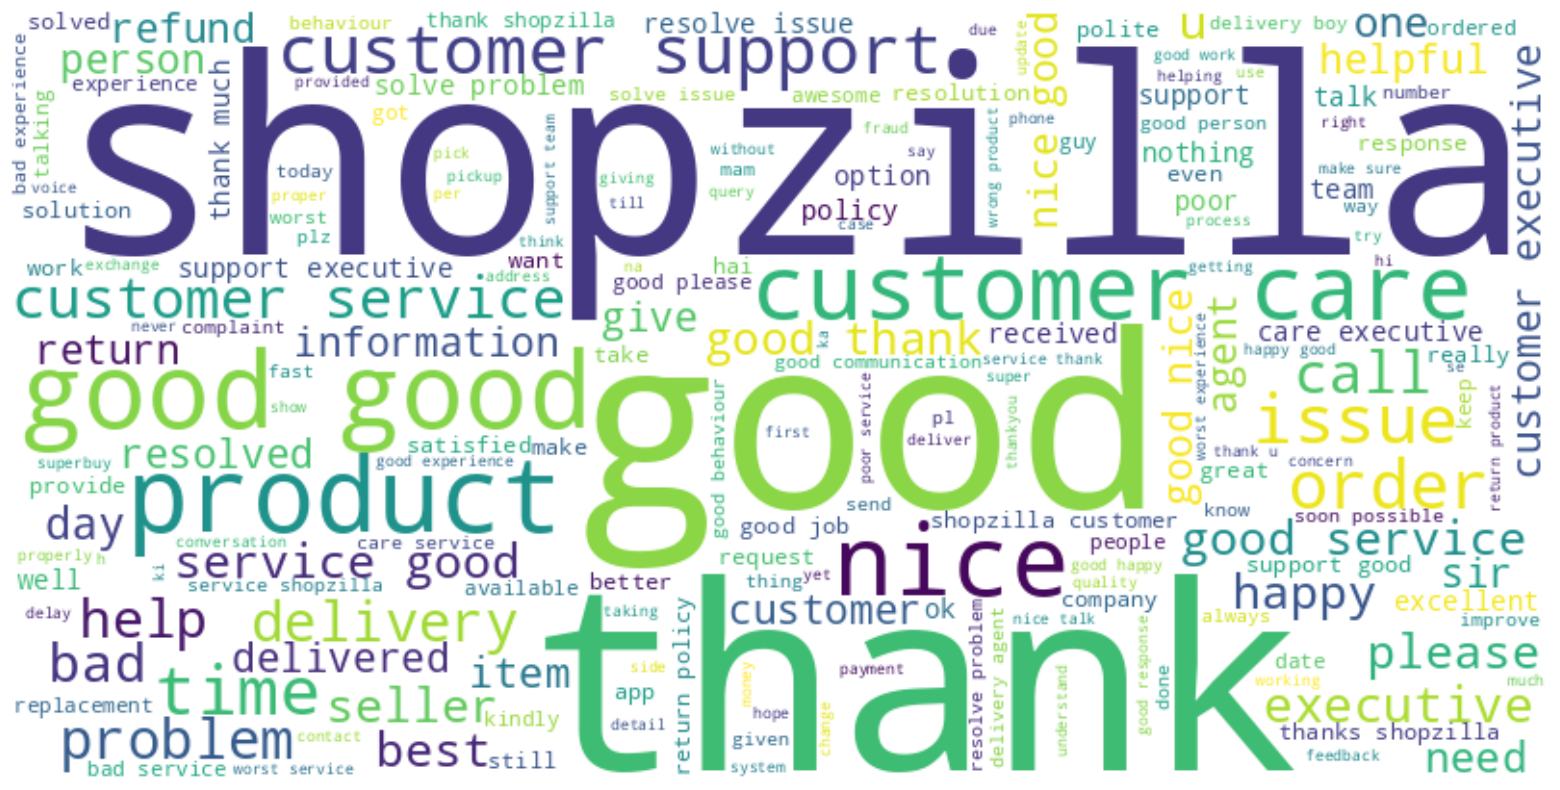

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)



stop_words = set(stopwords.words('english'))
negation_words = {"not", "no", "never", "none", "nobody", "nothing", "nowhere", "ne", "n't"}
stop_words = stop_words - negation_words # keep negation words


def review_to_words(review):
    """Convert a raw review string into a sequence of words for sentiment analysis."""

    # remove HTML tags
    review=BeautifulSoup(review, "html5lib").get_text()

    # remove punctuation and numeric
    review = re.sub(r"[^a-zA-Z]", " ", review)

    # lowercase
    review = review.lower()

    # tokenize
    review = nltk.word_tokenize(review)

    # remove stop words (excluding negations)
    review = [w for w in review if w not in stop_words]

    # Join words back into a string
    return ' '.join(review)


df['cleaned_remarks'] = df['Customer Remarks'].apply(review_to_words)
#display(df[['Customer Remarks', 'cleaned_remarks']].head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# cleaned remarks into a single string
all_remarks = " ".join(df['cleaned_remarks'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_remarks)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature engineering


In [ ]:
#Convert the text data into numerical features that can be used by a machine learning model. Techniques like TF-IDF or word embeddings (e.g., Word2Vec, GloVe) can be used.
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_remarks'])

print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (85907, 9443)


## Model Training

In [ ]:
# Train a sentiment analysis model using the numerical features CSAT Score derived from the 'Customer Remarks'.

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Use CSAT Score as a proxy for sentiment where higher scores are positive.

target_variable = 'CSAT Score'
y = df[target_variable]

# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

print("--Training done--")


--Training done--


In [ ]:

# Make predictions on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.18      0.29      2241
           2       0.00      0.00      0.00       227
           3       0.00      0.00      0.00       503
           4       0.50      0.00      0.00      2277
           5       0.71      1.00      0.83     11934

    accuracy                           0.71     17182
   macro avg       0.40      0.24      0.22     17182
weighted avg       0.66      0.71      0.62     17182



## Sentiment Mapping


In [ ]:
# Map the 'CSAT Score' to sentiment categories and retrain to address class imbalance and provide a more appropriate target for sentiment analysis.

# mapping Function to map CSAT scores to sentiment categories
def map_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    elif score in [4, 5]:
        return 'Positive'
    else:
        return None

# Apply to create a new 'Sentiment' column
df['Sentiment'] = df['CSAT Score'].apply(map_sentiment)

display(df['Sentiment'].value_counts())

# Drop rows where sentiment could not be mapped
df.dropna(subset=['Sentiment'], inplace=True)

,count
Sentiment,
Positive,70836
Negative,12513
Neutral,2558


In [ ]:
# Retrain model with mapped sentiment

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

target_variable = 'Sentiment'
y = df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

print("--Training done--")

# Make predictions on the test set
y_pred = nb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

--Training done--
Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.15      0.25      2468
     Neutral       0.00      0.00      0.00       503
    Positive       0.85      1.00      0.91     14211

    accuracy                           0.84     17182
   macro avg       0.55      0.38      0.39     17182
weighted avg       0.81      0.84      0.79     17182





---



---



---



---



# Improvement v1

### Shift focus to be more business objective driven e.g. New Focus to be Maximizing Negative Sentiment Detection for Improving Customer Experience

- **Prioritize negative sentiment recall** (≥85% target)
- **Improve customer experience** by identifying unhappy customers early
- **Leverage multiple data sources** beyond just text column
- **Handle severe class imbalance** more effectively via **SMOTE**

### Key Improvements Over Previous BaseLine Version:
*
*
*
*

In [7]:
# Load packages & libraries

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

# Advanced text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import spacy

# Advanced ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Advanced metrics and evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    roc_auc_score, average_precision_score, f1_score, recall_score,
    precision_score, roc_curve, auc
)

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## Data Loading and Additional Exploration

In [5]:
#
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from datasets import Dataset
import json
import pandas as pd

df = pd.read_csv('drive/MyDrive/Colab Notebooks/Cathys_test_IZ/dataset.csv')

# Convert 'order_date_time' to datetime, coercing errors
df['order_date_time'] = pd.to_datetime(df['order_date_time'], errors='coerce')

# Data quality assessment
print("\n🔍 DATA QUALITY ASSESSMENT")
print("=" * 50)

# Text data availability
text_availability = {
    'Total records': len(df),
    'Records with customer remarks': df['Customer Remarks'].notna().sum(),
    'Records with empty remarks': (df['Customer Remarks'] == '').sum(),
    'Usable text records': df['Customer Remarks'].notna().sum() - (df['Customer Remarks'] == '').sum()
}

for key, value in text_availability.items():
    percentage = (value / len(df)) * 100 if len(df) > 0 else 0
    print(f"{key}: {value:,} ({percentage:.1f}%)")

# CSAT Score distribution (our sentiment proxy)
print("\n CSAT SCORE DISTRIBUTION")
csat_dist = df['CSAT Score'].value_counts().sort_index()
for score, count in csat_dist.items():
    percentage = (count / len(df)) * 100
    sentiment = 'Negative' if score <= 2 else 'Neutral' if score == 3 else 'Positive'
    print(f"Score {score} ({sentiment}): {count:,} ({percentage:.1f}%)")

# Channel and category insights
print("\n By CHANNEL")
print(df['channel_name'].value_counts().head())

print("\n TOP ISSUE CATEGORIES")
print(df['category'].value_counts().head())

Mounted at /content/drive

🔍 DATA QUALITY ASSESSMENT
Total records: 85,907 (100.0%)
Records with customer remarks: 28,742 (33.5%)
Records with empty remarks: 0 (0.0%)
Usable text records: 28,742 (33.5%)

 CSAT SCORE DISTRIBUTION
Score 1 (Negative): 11,230 (13.1%)
Score 2 (Negative): 1,283 (1.5%)
Score 3 (Neutral): 2,558 (3.0%)
Score 4 (Positive): 11,219 (13.1%)
Score 5 (Positive): 59,617 (69.4%)

 By CHANNEL
channel_name
Inbound    68142
Outcall    14742
Email       3023
Name: count, dtype: int64

 TOP ISSUE CATEGORIES
category
Returns              44097
Order Related        23215
Refund Related        4550
Product Queries       3692
Shopzilla Related     2792
Name: count, dtype: int64


## Advanced Text Preprocessing

### Similar Cleansing with Key Improvements:
- **Negation handling**: Preserve "not good" vs "good"
- **Use Lemmatization**
- **Prepare Prepare a comprehensive feature set** : Text Features, Sentiment Features
- **Domain-specific cleaning**: Customer service terminology
- **Sentiment-aware preprocessing**: Preserve emotional indicators

In [12]:
# 2. Advanced Text Preprocessing

def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers, keeping only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Handle negations (simple approach: add "_not" to the next word)
    words = text.split()
    new_words = []
    i = 0
    while i < len(words):
        if words[i] in ['not', 'no', 'n\'t'] and i + 1 < len(words):
            new_words.append(words[i] + '_' + words[i+1])
            i += 2
        else:
            new_words.append(words[i])
            i += 1
    text = ' '.join(new_words)

    # Tokenization (using NLTK)
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

df['cleaned_remarks'] = df['Customer Remarks'].apply(preprocess_text)

# Add basic text features
df['text_length'] = df['cleaned_remarks'].apply(len)
df['word_count'] = df['cleaned_remarks'].apply(lambda x: len(x.split()))
df['exclamation_count'] = df['Customer Remarks'].astype(str).apply(lambda x: x.count('!'))
df['question_count'] = df['Customer Remarks'].astype(str).apply(lambda x: x.count('?'))
df['caps_ratio'] = df['Customer Remarks'].astype(str).apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1))

# Add basic sentiment features using TextBlob
df['sentiment_polarity'] = df['Customer Remarks'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_subjectivity'] = df['Customer Remarks'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)

display(df[['Customer Remarks', 'cleaned_remarks', 'text_length', 'word_count', 'sentiment_polarity','sentiment_subjectivity']].head(50))

,Customer Remarks,cleaned_remarks,text_length,word_count,sentiment_polarity,sentiment_subjectivity
0,NaN,,0,0,0.000,0.000000
1,NaN,,0,0,0.000,0.000000
2,NaN,,0,0,0.000,0.000000
3,NaN,,0,0,0.000,0.000000
4,NaN,,0,0,0.000,0.000000
5,NaN,,0,0,0.000,0.000000
6,NaN,,0,0,0.000,0.000000
7,Very good,good,4,1,0.910,0.780000
8,Shopzilla app and it's all coustomer care services is very good service provided all time,shopzilla app coustomer care service good service provided time,63,9,0.910,0.780000
9,NaN,,0,0,0.000,0.000000


## Enhanced Feature Engineering

### Multi-Modal Feature Approach:


*   List item
*   List item

